# Probablistic model building genetic algorithm

In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from notebooks.runAmber import get_uniform_ms, get_finkelstein_ms

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0zduxvda because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.


0.1.1-ga


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
x = np.load('./data/compiled_X.npy')
y = np.load('./data/compiled_Y.npy')
with open('./data/y_col_annot.txt', 'r') as f:
    label_annot = [x.strip() for x in f]
    label_annot = {x:i for i,x in enumerate(label_annot)}
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)
label_annot

{'wtCas9_cleave_rate_log': 0,
 'Cas9_enh_cleave_rate_log': 1,
 'Cas9_hypa_cleave_rate_log': 2,
 'Cas9_HF1_cleave_rate_log': 3,
 'wtCas9_cleave_rate_log_specificity': 4,
 'Cas9_enh_cleave_rate_log_specificity': 5,
 'Cas9_hypa_cleave_rate_log_specificity': 6,
 'Cas9_HF1_cleave_rate_log_specificity': 7,
 'wtCas9_ndABA': 8,
 'Cas9_enh_ndABA': 9,
 'Cas9_hypa_ndABA': 10,
 'Cas9_HF1_ndABA': 11}

In [5]:
target_idx = label_annot['wtCas9_cleave_rate_log']

## Setup AMBER

In [6]:
import amber
print(amber.__version__)
from amber.architect import pmbga
from amber.architect import ModelSpace, Operation

0.1.1-ga


In [7]:
#kinn_model_space = get_uniform_ms(n_states=4, st_win_size=7)

#print(kinn_model_space)

In [8]:
kinn_model_space = get_finkelstein_ms()
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [9]:
controller = pmbga.ProbaModelBuildGeneticAlgo(
            model_space=kinn_model_space,
            buffer_type='population',
            buffer_size=50,  # buffer size controlls the max history going back
            batch_size=1,   # batch size does not matter in this case; all arcs will be retrieved
        )

## Components before they are implemented in AMBER

In [10]:
## NEEDS RE-WORK
# poorman's manager get reward
def get_reward_pipeline(model_arcs, wd="./outputs/"):
    from warnings import simplefilter
    simplefilter(action='ignore', category=DeprecationWarning)
    tf.reset_default_graph()
    train_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph)
    model_params = modelSpace_to_modelParams(model_arcs)
    pickle.dump(model_params, open(os.path.join(wd, "model_params.pkl"), "wb"))
    with train_graph.as_default(), train_sess.as_default():
        kinn_test = KineticModel(model_params)
        mb = KineticNeuralNetworkBuilder(kinn=kinn_test, session=train_sess, 
            n_feats=25,
            n_channels=8,
            replace_conv_by_fc=False)
        # train and test
        mb.build(optimizer='adam', plot=False, output_act=False)
        model = mb.model
        x_train_b = mb.blockify_seq_ohe(x_train)
        x_test_b = mb.blockify_seq_ohe(x_test)
        checkpointer = ModelCheckpoint(
            filepath=os.path.join(wd,"bestmodel.h5"), mode='min', verbose=0, save_best_only=True,
            save_weights_only=True)
        earlystopper = EarlyStopping(
            monitor="val_loss",
            mode='min',
            patience=5,
            verbose=0)

        model.fit(x_train_b, y_train[:,target_idx],
                  batch_size=128,
                  validation_split=0.2,
                  callbacks=[checkpointer, earlystopper],
                  epochs=75, verbose=0)
        y_hat = model.predict(x_test_b).flatten()
        test_pcc = ss.pearsonr(y_hat, y_test[:,target_idx])[0]
    tf.keras.backend.clear_session()
    del train_graph, train_sess
    gc.collect()
    return test_pcc

## A fancy For-Loop that does the work for `amber.architect.trainEnv`

In [11]:
# trainEnv parameters
samps_per_gen = 10   # how many arcs to sample in each generation; important
max_gen = 1500
epsilon = 0.05
patience = 200
n_warmup_gen = -1
wd = "outputs/notebook"

In [12]:
def compute_eps(model_space_probs, old_probs=None):
    delta = []
    samp_probs = {}
    for p in model_space_probs:
        #print(p)
        samp_probs[p] = model_space_probs[p].sample(size=10000)
        n = np.percentile(samp_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
        if old_probs is None:
            delta.append( np.mean(np.abs(n)) )
        else:
            o = np.percentile(old_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
            delta.append( np.mean(np.abs(o - n)) )
    return np.mean(delta), samp_probs 

# get prior probas
_, old_probs = compute_eps(controller.model_space_probs)

In [13]:
hist = []
pc_cnt = 0
best_indv = 0
stat_df = pd.DataFrame(columns=['Generation', 'GenAvg', 'Best', 'PostVar'])
for generation in range(max_gen):
    try:
        start = time.time()
        has_impr = False
        for _ in range(samps_per_gen):
            # get arc
            arc, _ = controller.get_action()
            # get reward
            try:
                test_pcc = get_reward_pipeline(arc, wd=wd)
            #except ValueError:
            #    test_pcc = 0
            except Exception as e:
                raise e
            rate_df = None
            # update best, or increase patience counter
            if test_pcc > best_indv:
                best_indv = test_pcc
                has_impr = True
                shutil.move(os.path.join(wd, "bestmodel.h5"), os.path.join(wd, "AmberSearchBestModel.h5"))
                shutil.move(os.path.join(wd, "model_params.pkl"), os.path.join(wd, "AmberSearchBestModel_config.pkl"))

            # store
            _ = controller.store(action=arc, reward=test_pcc)
            hist.append({'gen': generation, 'arc':arc, 'test_pcc': test_pcc, 'rate_df': rate_df})
        end = time.time()
        if generation < n_warmup_gen:
            print(f"Gen {generation} < {n_warmup_gen} warmup.. skipped - Time %.2f" % (end-start), flush=True)
            continue
        _ = controller.train(episode=generation, working_dir=".")
        delta, old_probs = compute_eps(controller.model_space_probs, old_probs)
        post_vars = [np.var(x.sample(size=100)) for _, x in controller.model_space_probs.items()]
        stat_df = stat_df.append({
            'Generation': generation,
            'GenAvg': controller.buffer.r_bias,
            'Best': best_indv,
            'PostVar': np.mean(post_vars)
        }, ignore_index=True)
        print("[%s] Gen %i - Mean fitness %.3f - Best %.4f - PostVar %.3f - Eps %.3f - Time %.2f" % (
            datetime.now().strftime("%H:%M:%S"),
            generation, 
            controller.buffer.r_bias, 
            best_indv, 
            np.mean(post_vars),
            delta,
            end-start), flush=True)
        #if delta < epsilon:
        #    print("stop due to convergence criteria")
        #    break
        pc_cnt = 0 if has_impr else pc_cnt+1
        if pc_cnt >= patience:
            print("early-stop due to max patience w/o improvement")
            break
    except KeyboardInterrupt:
        print("user interrupted")
        break

datapoints:  7 / total:  10
[10:05:17] Gen 0 - Mean fitness 0.687 - Best 0.7784 - PostVar 5.915 - Eps 0.659 - Time 91.07
datapoints:  12 / total:  20
[10:06:57] Gen 1 - Mean fitness 0.677 - Best 0.7784 - PostVar 5.854 - Eps 0.289 - Time 99.58
datapoints:  19 / total:  30
[10:08:32] Gen 2 - Mean fitness 0.653 - Best 0.7784 - PostVar 6.174 - Eps 0.252 - Time 93.39
datapoints:  18 / total:  40
[10:10:09] Gen 3 - Mean fitness 0.703 - Best 0.7784 - PostVar 5.893 - Eps 0.370 - Time 96.99
datapoints:  25 / total:  50
[10:11:39] Gen 4 - Mean fitness 0.702 - Best 0.7784 - PostVar 5.998 - Eps 0.178 - Time 89.13
datapoints:  31 / total:  60
[10:13:08] Gen 5 - Mean fitness 0.697 - Best 0.7784 - PostVar 6.032 - Eps 0.200 - Time 88.16
datapoints:  51 / total:  70
[10:14:47] Gen 6 - Mean fitness 0.648 - Best 0.7784 - PostVar 5.813 - Eps 0.252 - Time 97.62
datapoints:  47 / total:  80
[10:16:18] Gen 7 - Mean fitness 0.668 - Best 0.7784 - PostVar 5.638 - Eps 0.126 - Time 90.15
datapoints:  32 / total: 

datapoints:  309 / total:  500
[11:49:49] Gen 66 - Mean fitness 0.725 - Best 0.8126 - PostVar 5.015 - Eps 0.059 - Time 105.56
datapoints:  235 / total:  500
[11:51:31] Gen 67 - Mean fitness 0.744 - Best 0.8126 - PostVar 5.218 - Eps 0.096 - Time 101.14
datapoints:  309 / total:  500
[11:53:09] Gen 68 - Mean fitness 0.727 - Best 0.8126 - PostVar 5.075 - Eps 0.096 - Time 96.55
datapoints:  149 / total:  500
[11:54:44] Gen 69 - Mean fitness 0.764 - Best 0.8126 - PostVar 4.347 - Eps 0.289 - Time 94.19
datapoints:  235 / total:  500
[11:56:17] Gen 70 - Mean fitness 0.748 - Best 0.8126 - PostVar 4.783 - Eps 0.215 - Time 92.24
datapoints:  266 / total:  500
[11:57:50] Gen 71 - Mean fitness 0.741 - Best 0.8126 - PostVar 5.096 - Eps 0.052 - Time 92.25
datapoints:  220 / total:  500
[11:59:20] Gen 72 - Mean fitness 0.753 - Best 0.8126 - PostVar 4.862 - Eps 0.081 - Time 89.12
datapoints:  275 / total:  500
[12:00:49] Gen 73 - Mean fitness 0.740 - Best 0.8126 - PostVar 4.811 - Eps 0.067 - Time 88.1

datapoints:  188 / total:  500
[13:30:34] Gen 132 - Mean fitness 0.780 - Best 0.8205 - PostVar 4.172 - Eps 0.059 - Time 89.43
datapoints:  414 / total:  500
[13:32:05] Gen 133 - Mean fitness 0.739 - Best 0.8205 - PostVar 4.197 - Eps 0.200 - Time 90.21
datapoints:  242 / total:  500
[13:33:37] Gen 134 - Mean fitness 0.774 - Best 0.8205 - PostVar 3.660 - Eps 0.185 - Time 91.46
datapoints:  317 / total:  500
[13:35:07] Gen 135 - Mean fitness 0.764 - Best 0.8211 - PostVar 3.727 - Eps 0.081 - Time 88.93
datapoints:  324 / total:  500
[13:36:40] Gen 136 - Mean fitness 0.764 - Best 0.8211 - PostVar 3.964 - Eps 0.007 - Time 91.83
datapoints:  346 / total:  500
[13:38:10] Gen 137 - Mean fitness 0.759 - Best 0.8211 - PostVar 4.063 - Eps 0.082 - Time 89.59
datapoints:  256 / total:  500
[13:39:42] Gen 138 - Mean fitness 0.771 - Best 0.8211 - PostVar 3.886 - Eps 0.112 - Time 90.96
datapoints:  136 / total:  500
[13:41:13] Gen 139 - Mean fitness 0.785 - Best 0.8211 - PostVar 4.121 - Eps 0.207 - Tim

datapoints:  374 / total:  500
[15:14:15] Gen 197 - Mean fitness 0.765 - Best 0.8265 - PostVar 3.956 - Eps 0.222 - Time 95.39
datapoints:  284 / total:  500
[15:16:00] Gen 198 - Mean fitness 0.779 - Best 0.8265 - PostVar 3.827 - Eps 0.037 - Time 103.06
datapoints:  224 / total:  500
[15:17:42] Gen 199 - Mean fitness 0.783 - Best 0.8265 - PostVar 3.497 - Eps 0.081 - Time 101.79
datapoints:  265 / total:  500
[15:19:18] Gen 200 - Mean fitness 0.781 - Best 0.8265 - PostVar 4.015 - Eps 0.067 - Time 94.34
datapoints:  457 / total:  500
[15:20:52] Gen 201 - Mean fitness 0.738 - Best 0.8265 - PostVar 3.700 - Eps 0.104 - Time 93.76
datapoints:  252 / total:  500
[15:22:27] Gen 202 - Mean fitness 0.782 - Best 0.8265 - PostVar 3.497 - Eps 0.089 - Time 93.66
datapoints:  303 / total:  500
[15:24:00] Gen 203 - Mean fitness 0.777 - Best 0.8265 - PostVar 3.376 - Eps 0.052 - Time 92.15
datapoints:  326 / total:  500
[15:25:35] Gen 204 - Mean fitness 0.774 - Best 0.8265 - PostVar 3.327 - Eps 0.030 - T

datapoints:  347 / total:  500
[16:59:09] Gen 262 - Mean fitness 0.777 - Best 0.8265 - PostVar 3.429 - Eps 0.053 - Time 93.93
datapoints:  97 / total:  500
[17:00:42] Gen 263 - Mean fitness 0.797 - Best 0.8265 - PostVar 3.199 - Eps 0.310 - Time 91.56
datapoints:  373 / total:  500
[17:02:15] Gen 264 - Mean fitness 0.774 - Best 0.8265 - PostVar 3.332 - Eps 0.333 - Time 91.87
datapoints:  139 / total:  500
[17:03:49] Gen 265 - Mean fitness 0.793 - Best 0.8265 - PostVar 3.415 - Eps 0.274 - Time 93.60
datapoints:  346 / total:  500
[17:05:31] Gen 266 - Mean fitness 0.778 - Best 0.8265 - PostVar 3.303 - Eps 0.259 - Time 100.70
datapoints:  441 / total:  500
[17:07:16] Gen 267 - Mean fitness 0.758 - Best 0.8265 - PostVar 3.387 - Eps 0.089 - Time 104.59
datapoints:  398 / total:  500
[17:08:52] Gen 268 - Mean fitness 0.770 - Best 0.8265 - PostVar 3.677 - Eps 0.052 - Time 94.94
datapoints:  390 / total:  500
[17:10:31] Gen 269 - Mean fitness 0.771 - Best 0.8265 - PostVar 3.362 - Eps 0.030 - Ti

datapoints:  225 / total:  500
[18:45:34] Gen 327 - Mean fitness 0.791 - Best 0.8340 - PostVar 2.918 - Eps 0.059 - Time 93.40
datapoints:  325 / total:  500
[18:47:12] Gen 328 - Mean fitness 0.783 - Best 0.8340 - PostVar 3.257 - Eps 0.096 - Time 96.90
datapoints:  278 / total:  500
[18:48:57] Gen 329 - Mean fitness 0.787 - Best 0.8340 - PostVar 3.315 - Eps 0.052 - Time 104.24
datapoints:  407 / total:  500
[18:50:35] Gen 330 - Mean fitness 0.770 - Best 0.8340 - PostVar 3.660 - Eps 0.044 - Time 97.31
datapoints:  289 / total:  500
[18:52:13] Gen 331 - Mean fitness 0.787 - Best 0.8340 - PostVar 3.447 - Eps 0.030 - Time 96.50
datapoints:  264 / total:  500
[18:53:50] Gen 332 - Mean fitness 0.789 - Best 0.8340 - PostVar 3.266 - Eps 0.007 - Time 96.18
datapoints:  251 / total:  500
[18:55:24] Gen 333 - Mean fitness 0.790 - Best 0.8340 - PostVar 3.157 - Eps 0.022 - Time 92.84
datapoints:  393 / total:  500
[18:57:05] Gen 334 - Mean fitness 0.774 - Best 0.8340 - PostVar 3.434 - Eps 0.052 - Ti

datapoints:  309 / total:  500
[20:29:58] Gen 392 - Mean fitness 0.788 - Best 0.8357 - PostVar 2.770 - Eps 0.030 - Time 90.97
datapoints:  332 / total:  500
[20:31:30] Gen 393 - Mean fitness 0.786 - Best 0.8357 - PostVar 3.026 - Eps 0.022 - Time 90.65
datapoints:  263 / total:  500
[20:33:02] Gen 394 - Mean fitness 0.791 - Best 0.8357 - PostVar 3.270 - Eps 0.037 - Time 90.88
datapoints:  269 / total:  500
[20:34:33] Gen 395 - Mean fitness 0.791 - Best 0.8357 - PostVar 3.216 - Eps 0.000 - Time 90.24
datapoints:  305 / total:  500
[20:36:05] Gen 396 - Mean fitness 0.789 - Best 0.8357 - PostVar 2.982 - Eps 0.015 - Time 91.21
datapoints:  161 / total:  500
[20:37:39] Gen 397 - Mean fitness 0.799 - Best 0.8357 - PostVar 3.324 - Eps 0.144 - Time 93.77
datapoints:  251 / total:  500
[20:39:16] Gen 398 - Mean fitness 0.793 - Best 0.8357 - PostVar 2.829 - Eps 0.121 - Time 95.19
datapoints:  294 / total:  500
[20:40:49] Gen 399 - Mean fitness 0.789 - Best 0.8357 - PostVar 3.070 - Eps 0.000 - Tim

[22:10:47] Gen 457 - Mean fitness 0.793 - Best 0.8357 - PostVar 2.869 - Eps 0.081 - Time 91.29
datapoints:  187 / total:  500
[22:12:20] Gen 458 - Mean fitness 0.798 - Best 0.8357 - PostVar 2.826 - Eps 0.141 - Time 91.45
datapoints:  165 / total:  500
[22:13:52] Gen 459 - Mean fitness 0.800 - Best 0.8357 - PostVar 3.332 - Eps 0.052 - Time 91.38
datapoints:  349 / total:  500
[22:15:24] Gen 460 - Mean fitness 0.787 - Best 0.8357 - PostVar 3.188 - Eps 0.148 - Time 91.40
datapoints:  366 / total:  500
[22:16:55] Gen 461 - Mean fitness 0.785 - Best 0.8357 - PostVar 3.349 - Eps 0.067 - Time 90.23
datapoints:  421 / total:  500
[22:18:28] Gen 462 - Mean fitness 0.772 - Best 0.8357 - PostVar 3.199 - Eps 0.059 - Time 91.25
datapoints:  263 / total:  500
[22:20:01] Gen 463 - Mean fitness 0.794 - Best 0.8357 - PostVar 3.206 - Eps 0.163 - Time 92.74
datapoints:  191 / total:  500
[22:21:34] Gen 464 - Mean fitness 0.798 - Best 0.8357 - PostVar 2.952 - Eps 0.096 - Time 91.55
datapoints:  326 / tota

datapoints:  380 / total:  500
[23:53:08] Gen 523 - Mean fitness 0.783 - Best 0.8447 - PostVar 2.514 - Eps 0.015 - Time 94.31
datapoints:  234 / total:  500
[23:54:41] Gen 524 - Mean fitness 0.797 - Best 0.8447 - PostVar 2.783 - Eps 0.067 - Time 92.51
datapoints:  321 / total:  500
[23:56:15] Gen 525 - Mean fitness 0.791 - Best 0.8447 - PostVar 2.525 - Eps 0.052 - Time 93.21
datapoints:  245 / total:  500
[23:57:47] Gen 526 - Mean fitness 0.796 - Best 0.8447 - PostVar 2.295 - Eps 0.052 - Time 90.71
datapoints:  433 / total:  500
[23:59:20] Gen 527 - Mean fitness 0.769 - Best 0.8447 - PostVar 2.967 - Eps 0.096 - Time 92.82
datapoints:  361 / total:  500
[00:00:55] Gen 528 - Mean fitness 0.786 - Best 0.8447 - PostVar 2.645 - Eps 0.052 - Time 93.30
datapoints:  353 / total:  500
[00:02:27] Gen 529 - Mean fitness 0.787 - Best 0.8447 - PostVar 2.578 - Eps 0.000 - Time 91.72
datapoints:  173 / total:  500
[00:04:00] Gen 530 - Mean fitness 0.801 - Best 0.8447 - PostVar 2.558 - Eps 0.119 - Tim

[01:34:09] Gen 588 - Mean fitness 0.799 - Best 0.8447 - PostVar 2.490 - Eps 0.052 - Time 90.85
datapoints:  299 / total:  500
[01:35:43] Gen 589 - Mean fitness 0.797 - Best 0.8447 - PostVar 2.402 - Eps 0.081 - Time 93.57
datapoints:  352 / total:  500
[01:37:16] Gen 590 - Mean fitness 0.792 - Best 0.8447 - PostVar 2.633 - Eps 0.037 - Time 91.40
datapoints:  448 / total:  500
[01:38:49] Gen 591 - Mean fitness 0.769 - Best 0.8447 - PostVar 2.581 - Eps 0.052 - Time 92.15
datapoints:  442 / total:  500
[01:40:26] Gen 592 - Mean fitness 0.775 - Best 0.8447 - PostVar 2.782 - Eps 0.030 - Time 96.40
datapoints:  311 / total:  500
[01:41:59] Gen 593 - Mean fitness 0.795 - Best 0.8447 - PostVar 2.591 - Eps 0.059 - Time 92.36
datapoints:  230 / total:  500
[01:43:32] Gen 594 - Mean fitness 0.800 - Best 0.8447 - PostVar 2.848 - Eps 0.089 - Time 92.36
datapoints:  411 / total:  500
[01:45:04] Gen 595 - Mean fitness 0.783 - Best 0.8447 - PostVar 3.061 - Eps 0.104 - Time 90.61
datapoints:  439 / tota

datapoints:  334 / total:  500
[03:18:47] Gen 654 - Mean fitness 0.798 - Best 0.8447 - PostVar 2.746 - Eps 0.015 - Time 91.64
datapoints:  239 / total:  500
[03:20:20] Gen 655 - Mean fitness 0.804 - Best 0.8447 - PostVar 2.354 - Eps 0.030 - Time 92.08
datapoints:  425 / total:  500
[03:21:56] Gen 656 - Mean fitness 0.783 - Best 0.8447 - PostVar 2.115 - Eps 0.030 - Time 94.66
datapoints:  406 / total:  500
[03:23:39] Gen 657 - Mean fitness 0.789 - Best 0.8447 - PostVar 2.498 - Eps 0.007 - Time 102.21
datapoints:  290 / total:  500
[03:25:20] Gen 658 - Mean fitness 0.802 - Best 0.8447 - PostVar 2.333 - Eps 0.030 - Time 99.82
datapoints:  266 / total:  500
[03:27:05] Gen 659 - Mean fitness 0.802 - Best 0.8447 - PostVar 2.362 - Eps 0.030 - Time 104.47
datapoints:  309 / total:  500
[03:28:47] Gen 660 - Mean fitness 0.800 - Best 0.8447 - PostVar 2.300 - Eps 0.038 - Time 100.45
datapoints:  298 / total:  500
[03:30:23] Gen 661 - Mean fitness 0.801 - Best 0.8447 - PostVar 2.196 - Eps 0.016 - 

datapoints:  428 / total:  500
[05:01:55] Gen 719 - Mean fitness 0.780 - Best 0.8447 - PostVar 2.084 - Eps 0.015 - Time 94.68
datapoints:  258 / total:  500
[05:03:28] Gen 720 - Mean fitness 0.803 - Best 0.8447 - PostVar 1.916 - Eps 0.044 - Time 92.36
early-stop due to max patience w/o improvement


In [14]:
pd.DataFrame(hist).sort_values('test_pcc', ascending=False)

,gen,arc,test_pcc,rate_df
5205,520,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.844699,None
5534,553,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.840241,None
3752,375,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.835657,None
6376,637,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.835460,None
3007,300,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.834038,None
...,...,...,...,...
347,34,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.551123,None
15,1,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.548218,None
190,19,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.539044,None
426,42,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.518776,None


In [15]:
print("\n".join([str(x) 
                 for x in pd.DataFrame(hist).
                 sort_values('test_pcc', ascending=False).
                 head(1)['arc'].values[0]]))

conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'kernel_size': 3, 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'kernel_size': 3, 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 7, 'RANGE_D': 9}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 7}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 16, 'RANGE_D': 5}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '2', 'kernel_size': 5, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 14, 'RANGE_D': 6}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '0', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 10, 'CONTRIB': 1}


In [16]:
a = pd.DataFrame(hist)
a['arc'] = ['|'.join([f"{x.Layer_attributes['RANGE_ST']}-{x.Layer_attributes['RANGE_ST']+x.Layer_attributes['RANGE_D']}" for x in entry]) for entry in a['arc']]
a.drop(columns=['rate_df'], inplace=True)
a.to_csv(os.path.join(wd,"train_history.tsv"), sep="\t", index=False)

Text(0.5, 0, 'Generation')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


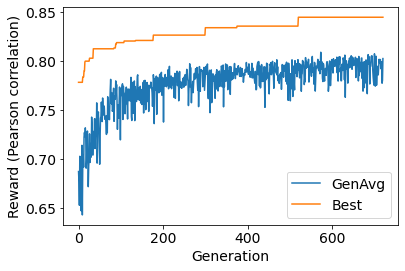

In [17]:
%matplotlib inline

ax = stat_df.plot.line(x='Generation', y=['GenAvg', 'Best'])
ax.set_ylabel("Reward (Pearson correlation)")
ax.set_xlabel("Generation")
#plt.savefig("reward_vs_time.png")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


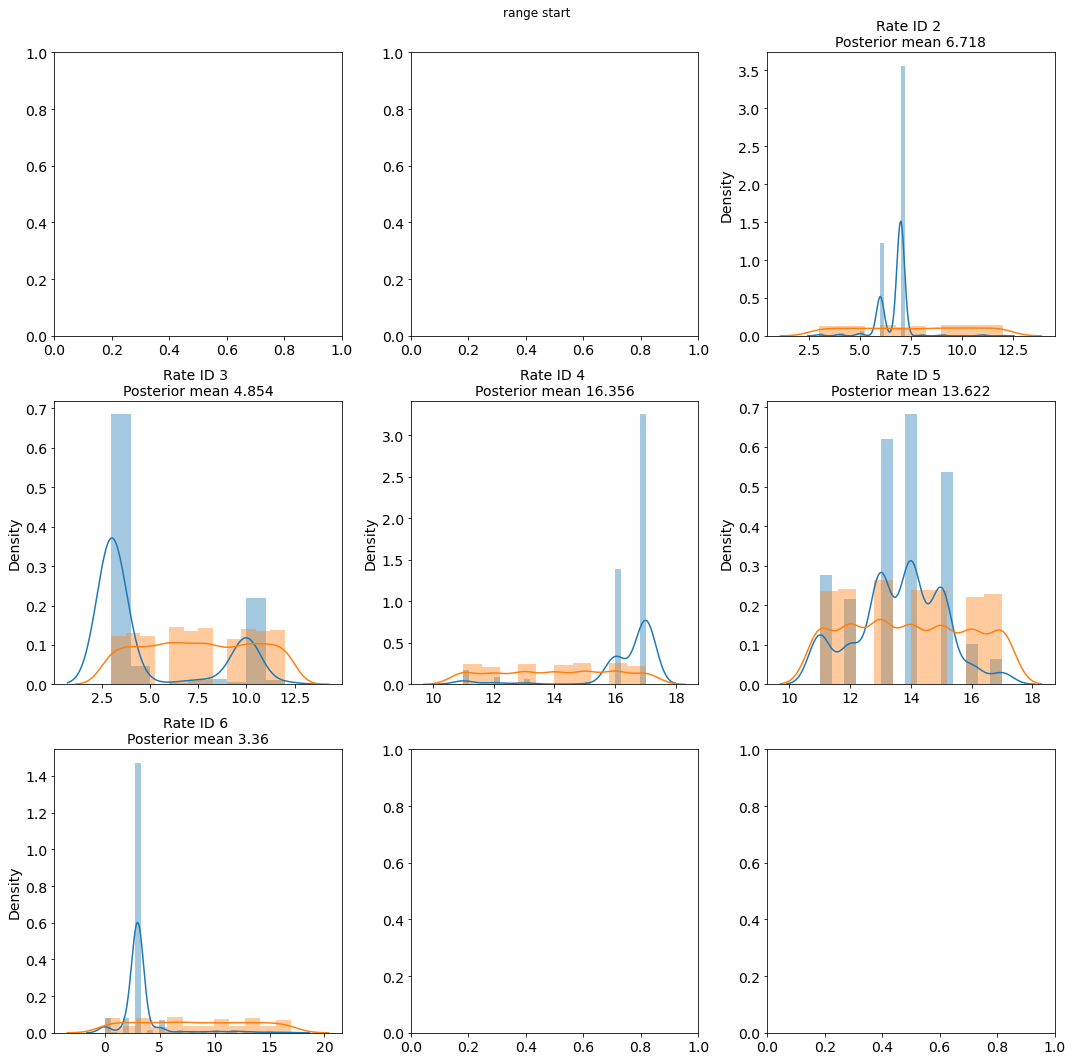

In [18]:
# START SITE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_ST':
        try:
            d = controller.model_space_probs[k].sample(size=1000)
        except:
            continue
        ax = axs[k[0]]
        sns.distplot(d, label="Post", ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))

        #_ = ax.set_xlim(0,50)

fig.suptitle('range start')
fig.tight_layout()
#fig.savefig("range_st.png")

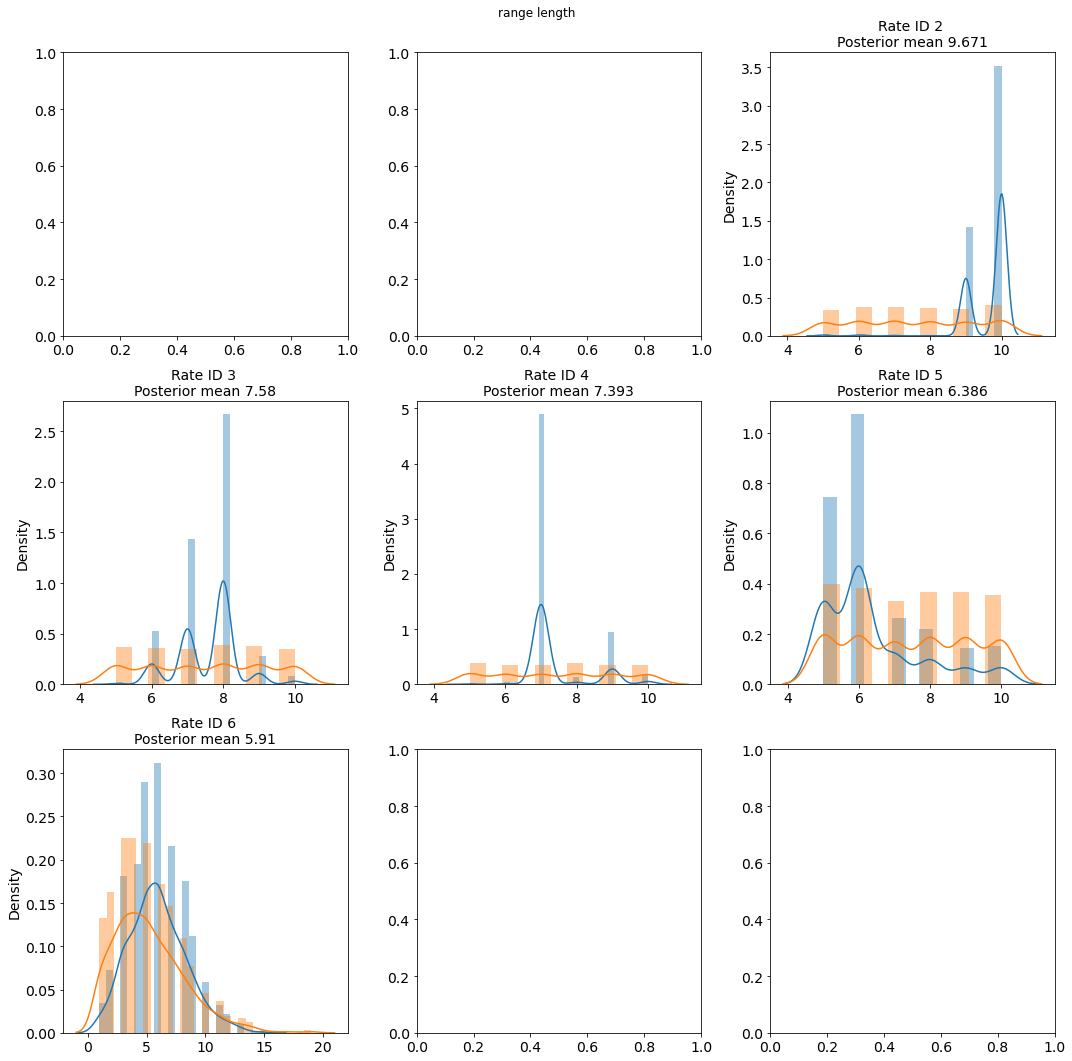

In [19]:
# CONV RANGE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_D':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
                ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
fig.suptitle('range length')
fig.tight_layout()
#fig.savefig("range_d.png")

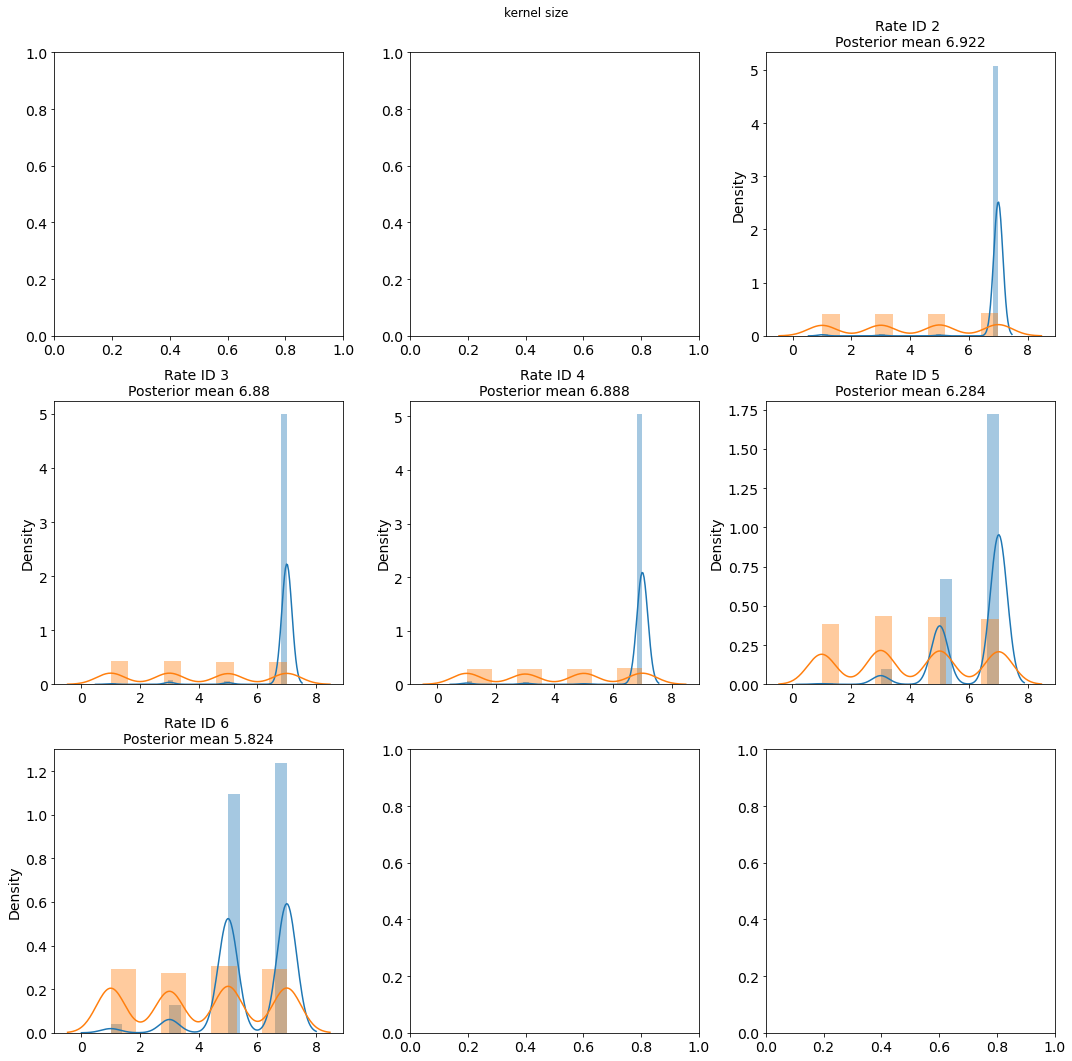

In [20]:
# KERNEL SIZE 
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'kernel_size':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
        #_ = ax.set_xlim(0,20) 
fig.suptitle('kernel size')
fig.tight_layout()

In [91]:
# reload and re-train to full convergence
%run notebooks/reload

<Figure size 432x288 with 0 Axes>

In [92]:
pickle.load(open("outputs/notebook/AmberSearchBestModel_config.pkl", "rb"))

{'States': ['3', '0', '1', '2'],
 'Rates': [{'name': 'k_01',
   'state_list': ['0', '1'],
   'input_range': [0, 3],
   'kernel_size': 3,
   'filters': 1,
   'SOURCE': '0',
   'TARGET': '1',
   'padding': 'valid',
   'EDGE': 1,
   'RANGE_ST': 0,
   'RANGE_D': 3},
  {'name': 'k_10',
   'state_list': ['1', '0'],
   'input_range': [0, 3],
   'kernel_size': 3,
   'filters': 1,
   'SOURCE': '1',
   'TARGET': '0',
   'padding': 'valid',
   'EDGE': 1,
   'RANGE_ST': 0,
   'RANGE_D': 3},
  {'name': 'k_12',
   'state_list': ['1', '2'],
   'input_range': [7, 16],
   'kernel_size': 7,
   'filters': 1,
   'SOURCE': '1',
   'TARGET': '2',
   'padding': 'same',
   'EDGE': 1,
   'RANGE_ST': 7,
   'RANGE_D': 9},
  {'name': 'k_21',
   'state_list': ['2', '1'],
   'input_range': [3, 10],
   'kernel_size': 7,
   'filters': 1,
   'SOURCE': '2',
   'TARGET': '1',
   'padding': 'same',
   'EDGE': 1,
   'RANGE_ST': 3,
   'RANGE_D': 7},
  {'name': 'k_23',
   'state_list': ['2', '3'],
   'input_range': [16, 21]

In [119]:
mb = reload_from_dir("outputs/notebook", replace_conv_by_fc=False, n_channels=8)
model = mb.model

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0_3 (InputLayer)          [(None, 3, 8)]       0                                            
__________________________________________________________________________________________________
input_7_16 (InputLayer)         [(None, 9, 8)]       0                                            
__________________________________________________________________________________________________
input_3_10 (InputLayer)         [(None, 7, 8)]       0                                            
__________________________________________________________________________________________________
input_16_21 (InputLayer)        [(None, 5, 8)]       0                                            
___________________________________________________________________________________________

In [120]:
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)
checkpointer = ModelCheckpoint(
    filepath=os.path.join(wd,"bestmodel.h5"), mode='min', verbose=0, save_best_only=True,
    save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=15,
    verbose=0)

model.fit(x_train_b, y_train[:,target_idx],
          batch_size=32,
          validation_split=0.2,
          callbacks=[checkpointer, earlystopper],
          epochs=205, verbose=2)
model.load_weights(os.path.join(wd,"bestmodel.h5"))
y_hat = model.predict(x_test_b).flatten()
test_pcc = ss.pearsonr(y_hat, y_test[:,target_idx])[0]

Train on 3186 samples, validate on 797 samples
Epoch 1/205
3186/3186 - 3s - loss: 0.4013 - val_loss: 0.3990
Epoch 2/205
3186/3186 - 0s - loss: 0.3938 - val_loss: 0.4144
Epoch 3/205
3186/3186 - 0s - loss: 0.3900 - val_loss: 0.3906
Epoch 4/205
3186/3186 - 0s - loss: 0.3898 - val_loss: 0.3866
Epoch 5/205
3186/3186 - 0s - loss: 0.3867 - val_loss: 0.3855
Epoch 6/205
3186/3186 - 0s - loss: 0.3798 - val_loss: 0.3789
Epoch 7/205
3186/3186 - 0s - loss: 0.3730 - val_loss: 0.3767
Epoch 8/205
3186/3186 - 0s - loss: 0.3667 - val_loss: 0.3704
Epoch 9/205
3186/3186 - 0s - loss: 0.3656 - val_loss: 0.3675
Epoch 10/205
3186/3186 - 0s - loss: 0.3609 - val_loss: 0.3621
Epoch 11/205
3186/3186 - 0s - loss: 0.3584 - val_loss: 0.3516
Epoch 12/205
3186/3186 - 0s - loss: 0.3565 - val_loss: 0.3547
Epoch 13/205
3186/3186 - 0s - loss: 0.3551 - val_loss: 0.3955
Epoch 14/205
3186/3186 - 0s - loss: 0.3510 - val_loss: 0.3574
Epoch 15/205
3186/3186 - 0s - loss: 0.3462 - val_loss: 0.3472
Epoch 16/205
3186/3186 - 0s - lo

3186/3186 - 0s - loss: 0.2977 - val_loss: 0.2914
Epoch 133/205
3186/3186 - 0s - loss: 0.2991 - val_loss: 0.2955
Epoch 134/205
3186/3186 - 0s - loss: 0.2988 - val_loss: 0.2872
Epoch 135/205
3186/3186 - 0s - loss: 0.3043 - val_loss: 0.2931
Epoch 136/205
3186/3186 - 0s - loss: 0.3007 - val_loss: 0.2900
Epoch 137/205
3186/3186 - 0s - loss: 0.3114 - val_loss: 0.2924
Epoch 138/205
3186/3186 - 0s - loss: 0.2984 - val_loss: 0.2881
Epoch 139/205
3186/3186 - 0s - loss: 0.3029 - val_loss: 0.2893
Epoch 140/205
3186/3186 - 0s - loss: 0.2956 - val_loss: 0.2906
Epoch 141/205
3186/3186 - 0s - loss: 0.3008 - val_loss: 0.2853
Epoch 142/205
3186/3186 - 0s - loss: 0.3051 - val_loss: 0.2924
Epoch 143/205
3186/3186 - 0s - loss: 0.2977 - val_loss: 0.2886
Epoch 144/205
3186/3186 - 0s - loss: 0.2992 - val_loss: 0.2927
Epoch 145/205
3186/3186 - 0s - loss: 0.2993 - val_loss: 0.3056
Epoch 146/205
3186/3186 - 0s - loss: 0.2967 - val_loss: 0.3170
Epoch 147/205
3186/3186 - 0s - loss: 0.2991 - val_loss: 0.2912
Epoch 

In [121]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [0, 3], 'kernel_size': 3, 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [0, 3], 'kernel_size': 3, 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [7, 16], 'kernel_size': 7, 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 7, 'RANGE_D': 9, 'template': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [3, 10], 'kernel_size': 7, 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 7, 'template': None}",
 "{'name': 'k_23', 'state_list': ['2', '3'], 'input_range': [16, 21], 'kernel_size': 7, 'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'padding': 'same', 'EDGE': 1

In [122]:
layer_dict = {l.name:l for l in model.layers}

In [123]:
np.around(layer_dict['conv_k0'].get_weights()[0],3)

array([[[ 0.   ],
        [ 0.   ],
        [ 0.531],
        [ 0.   ],
        [-0.021],
        [-0.008],
        [ 0.   ],
        [-0.007]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.531],
        [ 0.   ],
        [-0.009],
        [-0.016],
        [ 0.   ],
        [-0.013]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.531],
        [-0.001],
        [ 0.083],
        [-0.138],
        [ 0.   ]]], dtype=float32)

spearman SpearmanrResult(correlation=0.8625640492910754, pvalue=2.2302072822841933e-296)
pearson (0.8874005768814649, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.887')

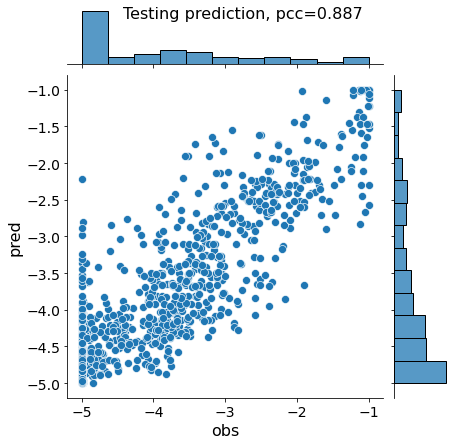

In [124]:
x_test_b = mb.blockify_seq_ohe(x_test)
y_hat = model.predict(x_test_b).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test[:,target_idx], y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test[:,target_idx]))
p = ss.pearsonr(y_hat, y_test[:,target_idx])
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)